13) MOCK DATASETS (don't use the AM207 ones):

    a) Use some ISM parameters that represent different components of the ISM e.g. leave ISM parameters at their prior values and each time vary one by 2 sigma. one bursty SFR environment (SFR - 2sigma), one leaky (x_out + 2), one low SFE environment. And then see how well you can retrieve those. You will also see, that the ISM parameters are correlated (the signal will be redistributed into ather ISM parameters). I suggest it this way because in a paper you can plot the different tracks, name them (bursty, leaky etc) and plot the mock star abundances at specific times. And then you can show how well you can retrieve them. Of course you will have to add observational uncertainties to your predicted abundances. You can test with very low observational uncertainties, but a fair test would be to use typical observational uncertainties. This doesn't need any error parameters per element.
    
    b) In a last step you will need to do the inference with a wrong yield set as well (only then the error parameters per element will also be needed).



In [1]:
%pylab inline
import os
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
from Chempy.cem_function import single_timestep_chempy
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


First we choose some SSP parameters:

In [2]:
global_params=[-2.3,-2.89]

In [27]:
# Use 5 time datapoints
times = np.linspace(2,13.8,10)

ism_priors = a.p0[2:]
ism_prior_widths = [0.3,0.1,0.1]

# Create 4 sets of ISM parameters
ism_params = np.ones((4,1))*ism_priors
ism_params[1,0]-=2*ism_prior_widths[0] # low SFE
ism_params[2,1]-=2*ism_prior_widths[1] # bursty SFR
ism_params[3,2]+=2*ism_prior_widths[2] # leaky ISM

In [28]:
full_params = np.zeros([len(ism_params)*len(times),6])
for i in range(len(full_params)):
    full_params[i]=np.asarray(list(global_params)+list(ism_params[i//len(times)])+[times[i%len(times)]])

In [29]:

def runner(par):
    """Function to compute the Chempy predictions for each parameter set"""
    b=ModelParameters()
    output=single_timestep_chempy((par,b))
    if type(output)==float:
        if output==np.inf:
            del b
        outs=np.zeros(len(els))
    else: 
        abun=output[0]
        del b;
        outs=abun
    return outs


In [30]:
import multiprocessing as mp
import tqdm

p=mp.Pool(4)
mock_abundances = np.asarray(list(tqdm.tqdm(p.imap(runner,full_params),total=len(full_params))))

  0%|          | 0/40 [00:00<?, ?it/s]/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time_model = float(basic_sfr.t[cut])
/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time_model = float(basic_sfr.t[cut])
/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be i

In [31]:
import time
init=time.time()
for _ in range(2):
    _,chempy_els=single_timestep_chempy((full_params[0],a))
print((time.time()-init)/2)

/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time_model = float(basic_sfr.t[cut])
/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sfr_at_end = float(basic_sfr.sfr[cut] / basic_sfr.dt)
/home/oliverphilcox/ChempyMulti/Chempy/wrapper.py:236: RuntimeWarning: invalid value encountered in subtract
  abundances[element] -= abundances['Fe']


0.558879017829895


In [32]:
np.asarray(chempy_els)

array(['C', 'Fe', 'H', 'He', 'Mg', 'N', 'Ne', 'O', 'Si'], dtype='<U2')

In [33]:
_,chempy_els=single_timestep_chempy((full_params[0],a))

/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:126: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  time_model = float(basic_sfr.t[cut])
/home/oliverphilcox/ChempyMulti/Chempy/cem_function.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sfr_at_end = float(basic_sfr.sfr[cut] / basic_sfr.dt)
/home/oliverphilcox/ChempyMulti/Chempy/wrapper.py:236: RuntimeWarning: invalid value encountered in subtract
  abundances[element] -= abundances['Fe']


Now plot data:

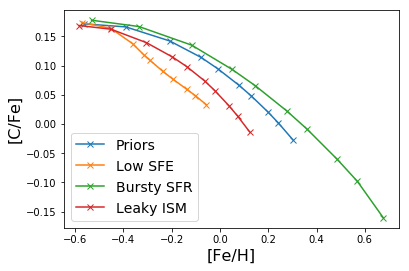

In [48]:
labels=['Priors','Low SFE','Bursty SFR','Leaky ISM'];FS=16
n_times = len(np.unique(full_params[:,-1]))
for i in range(4):
    plt.errorbar(mock_abundances[i*n_times:(i+1)*n_times,1],mock_abundances[i*n_times:(i+1)*n_times,0],
                marker='x',label=labels[i])
plt.ylabel('[C/Fe]',fontsize=FS);plt.xlabel('[Fe/H]',fontsize=FS);plt.legend(fontsize=FS-2)

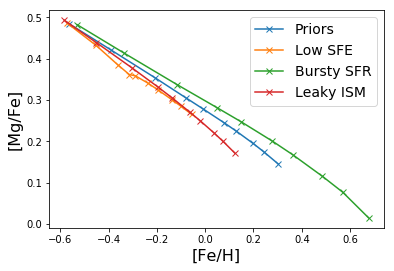

In [50]:
labels=['Priors','Low SFE','Bursty SFR','Leaky ISM'];FS=16
n_times = len(np.unique(full_params[:,-1]))
for i in range(4):
    plt.errorbar(mock_abundances[i*n_times:(i+1)*n_times,1],mock_abundances[i*n_times:(i+1)*n_times,4],
                marker='x',label=labels[i])
plt.ylabel('[Mg/Fe]',fontsize=FS);plt.xlabel('[Fe/H]',fontsize=FS);plt.legend(fontsize=FS-2)

Add TNG tracks:

In [55]:
dat=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/LC18_Abun/TNG_Mock_Data.npz')
all_abuns=dat.f.abundances
times=dat.f.true_time
dat.f.elements

array(['C', 'Fe', 'He', 'Mg', 'N', 'Ne', 'O', 'Si'], dtype='<U2')

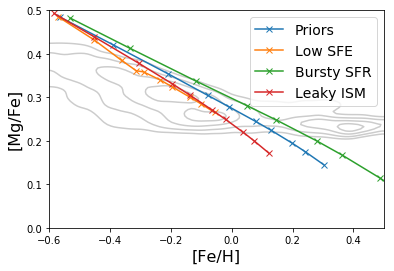

In [62]:
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.gca()

from corner import hist2d as cohist
x=all_abuns[:,1];y=all_abuns[:,3]
cohist(x,y,bins=100,range=[[-0.6,0.5,],[0,0.5]],smooth=2.,
       alpha=0.1,plot_density=False,plot_datapoints=False,no_fill_contours=True,contour_kwargs={'alpha':0.2})

labels=['Priors','Low SFE','Bursty SFR','Leaky ISM'];FS=16
n_times = len(np.unique(full_params[:,-1]))
for i in range(4):
    plt.errorbar(mock_abundances[i*n_times:(i+1)*n_times,1],mock_abundances[i*n_times:(i+1)*n_times,4],
                marker='x',label=labels[i])
plt.ylabel('[Mg/Fe]',fontsize=FS);plt.xlabel('[Fe/H]',fontsize=FS);plt.legend(fontsize=FS-2)


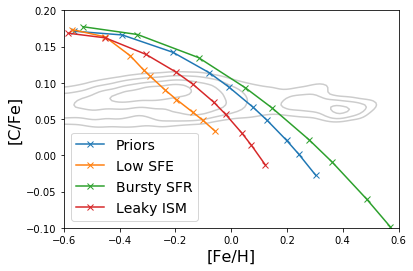

In [65]:
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.gca()

from corner import hist2d as cohist
x=all_abuns[:,1];y=all_abuns[:,0]
cohist(x,y,bins=100,range=[[-0.6,0.6],[-0.1,0.2]],smooth=2.,
       alpha=0.1,plot_density=False,plot_datapoints=False,no_fill_contours=True,contour_kwargs={'alpha':0.2})

labels=['Priors','Low SFE','Bursty SFR','Leaky ISM'];FS=16
n_times = len(np.unique(full_params[:,-1]))
for i in range(4):
    plt.errorbar(mock_abundances[i*n_times:(i+1)*n_times,1],mock_abundances[i*n_times:(i+1)*n_times,0],
                marker='x',label=labels[i])
plt.ylabel('[C/Fe]',fontsize=FS);plt.xlabel('[Fe/H]',fontsize=FS);plt.legend(fontsize=FS-2)

Use observational errors as solar errors here:

In [15]:
sol_dat = np.load('Chempy/input/stars/Proto-sun_all.npy')
sol_names = sol_dat.dtype.names
all_sol_errors = sol_dat[1]

In [16]:
obs_errors = np.zeros(len(a.initial_neural_names))
for i,el in enumerate(a.initial_neural_names):
    for j,el_sol in enumerate(sol_names):
        if str(el)==str(sol_names[j]):
            obs_errors[i]=all_sol_errors[j]
            break
        if j==len(sol_names)-1:
            print('Element %s not found'%el)
mock_ordered_abundances = np.zeros([len(mock_abundances),len(a.initial_neural_names)])        
for i,el in enumerate(a.initial_neural_names):
    for j,el_chempy in enumerate(chempy_els):
        if str(el)==str(chempy_els[j]):
            mock_ordered_abundances[:,i]=mock_abundances[:,j]
            break
        if j==len(chempy_els)-1:
            print('Element %s not found'%el)
        

In [17]:
np.asarray(a.initial_neural_names)

array(['C', 'Fe', 'He', 'Mg', 'N', 'Ne', 'O', 'Si'], dtype='<U2')

In [18]:
mock_errors = np.vstack([obs_errors for _ in range(len(mock_abundances))])

In [19]:
from scipy.stats import norm
time_mean = norm.rvs(loc=times,scale=0.5).round(2)
time_error = 0.5*np.ones_like(time_mean)
all_time_means = np.zeros(len(full_params))
all_time_stds = np.zeros(len(full_params))
for i in range(len(full_params)):
    all_time_means[i]=time_mean[i%len(times)]
    all_time_stds[i] = time_error[i%len(times)]

In [ ]:
plt.plot()

In [193]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/MockParams.npz',params=full_params,abundances=mock_ordered_abundances,
        time_mean = all_time_means, time_error = all_time_stds, abundance_error = mock_errors,elements=np.asarray(a.initial_neural_names,dtype=str))